# REINFORCE algorithm

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec, tensor_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import policy_step as ps
from tf_agents.typing import types
from tf_agents.metrics import py_metrics
from tf_agents.metrics import tf_metrics
from tf_agents.drivers import py_driver
from tf_agents.drivers import tf_driver
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import dynamic_step_driver
from tf_agents.policies import py_tf_eager_policy
from tf_agents.networks import actor_distribution_network
from tf_agents.networks import value_network
from tf_agents.agents import PPOClipAgent
from tf_agents.utils import common as cmn

import matplotlib.pyplot as plt
import qutip
from qutip import sigmap, expect

import random

import sys
sys.path.append('../')
from common.common import get_average_return, extract_single_action_policy

%matplotlib inline

2024-03-12 19:48:08.418197: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-12 19:48:08.446392: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 19:48:08.446415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 19:48:08.447187: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-12 19:48:08.451632: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-12 19:48:08.452227: I tensorflow/core/platform/cpu_feature_guard.cc:1

* System parameters

In [3]:
T = 5 # terminal time step
max_steps = 15 # number of time steps
random.seed(1991)

* Create training and evaluation environments and define actions

In [4]:
# validate environment
from environments.qubit_env import QubitResonantContEnv

# define actions
# TODO: actions can be continuous within a range of course 
# actions will be the change in the magnetic field
max_Ω = 1.0

environment = QubitResonantContEnv(T, max_steps, max_Ω, fidelity_threshold = 0.99, verbose_fg = False)
eval_environment = QubitResonantContEnv(T, max_steps, max_Ω, fidelity_threshold = 0.99, verbose_fg = False)

train_env = tf_py_environment.TFPyEnvironment(environment)
eval_env = tf_py_environment.TFPyEnvironment(eval_environment)

In [5]:
fc_layer_params = (100, 75)
learning_rate = 1e-3
replay_buffer_capacity = 10000
num_iterations = 500
nb_episodes = 1
eval_interval = 10
checkpoint_dir = "/home/dkoytrom/Msc_Quantum_Computing_Quantum_Technologies/Master_Thesis/algorithms/classical/Reinforcement_learning/checkpoints/ppo_clip_qubit_resonant_cont/"

In [6]:
actor_network = actor_distribution_network.ActorDistributionNetwork(
    input_tensor_spec = train_env.observation_spec(),
    output_tensor_spec = train_env.action_spec(),
    fc_layer_params = fc_layer_params,
    name = "Policy",
)

# use tha Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

train_step_counter = tf.Variable(0)

value_net = value_network.ValueNetwork(
    input_tensor_spec = train_env.observation_spec(),
    fc_layer_params = (100, 50, ),
    name = 'ValueNet'
) 

agent = PPOClipAgent(
    time_step_spec = train_env.time_step_spec(),
    action_spec = train_env.action_spec(),
    actor_net = actor_network,
    value_net = value_net,
    optimizer = optimizer,
    train_step_counter = train_step_counter,
    value_clipping = 0.2
)

agent.initialize()

2024-03-12 19:48:10.227579: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: dkoytrom-pc
2024-03-12 19:48:10.227594: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: dkoytrom-pc
2024-03-12 19:48:10.227667: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2024-03-12 19:48:10.227689: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 550.54.14


In [7]:
# collect trajectories
import reverb
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils

table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size = replay_buffer_capacity,
    sampler = reverb.selectors.Uniform(),
    remover = reverb.selectors.Fifo(),
    rate_limiter = reverb.rate_limiters.MinSize(1),
    signature = replay_buffer_signature
)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name = table_name,
    sequence_length = None,
    local_server = reverb_server
)

rb_observer = reverb_utils.ReverbAddEpisodeObserver(
    replay_buffer.py_client,
    table_name,
    replay_buffer_capacity
)

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = cmn.function(agent.train)

# Reset the train step.
# agent.train_step_counter.assign(0)

# create a driver which will run the simulations and collect tha dataset for our training
collect_driver = py_driver.PyDriver(
    environment,
    py_tf_eager_policy.PyTFEagerPolicy(agent.collect_policy, use_tf_function = True),
    observers = [rb_observer],
    max_episodes = nb_episodes
)

# create checkpointer to load training and continue
""" checkpointer = cmn.Checkpointer(
    ckpt_dir = checkpoint_dir,
    max_to_keep = 1,
    agent = agent,
    policy = agent.policy,
    replay_buffer = replay_buffer,
)

checkpointer.initialize_or_restore() """

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpkt71nwzw.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmpkt71nwzw
[reverb/cc/platform/default/server.cc:71] Started replay server on port 34089


' checkpointer = cmn.Checkpointer(\n    ckpt_dir = checkpoint_dir,\n    max_to_keep = 1,\n    agent = agent,\n    policy = agent.policy,\n    replay_buffer = replay_buffer,\n)\n\ncheckpointer.initialize_or_restore() '

In [8]:
avg_returns = [get_average_return(eval_env, agent.policy, 10)]

for _ in range(num_iterations):
    initial_time_step = environment.reset()
    collect_driver.run(initial_time_step)

    # create dataset from trajectories
    dataset = replay_buffer.as_dataset(sample_batch_size = 1)
    iterator = iter(dataset)

    trajectories , _ = next(iterator)

    # train 
    train_loss = agent.train(experience = trajectories)

    replay_buffer.clear()

    step = agent.train_step_counter.numpy()

    if step % 50 == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss.loss))

    if step % eval_interval == 0:
        avg_return = get_average_return(eval_env, agent.policy, 10)
        avg_returns.append(avg_return)


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (103619) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (103619) so Table uniform_table is accessed directly without gRPC.


step = 50: loss = -0.024878740310668945


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (103619) so Table uniform_table is accessed directly without gRPC.


step = 100: loss = -0.21810343861579895
step = 150: loss = 4.812146186828613


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (103619) so Table uniform_table is accessed directly without gRPC.


step = 200: loss = -0.2045448124408722
step = 250: loss = 23.751787185668945
step = 300: loss = 10.765562057495117
step = 350: loss = 4.174051284790039


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (103619) so Table uniform_table is accessed directly without gRPC.


step = 400: loss = 0.5046536922454834
step = 450: loss = 0.7988850474357605
step = 500: loss = -0.625732421875
step = 550: loss = -0.3266957104206085
step = 600: loss = -0.5270265340805054
step = 650: loss = 2.341533899307251
step = 700: loss = 0.08383229374885559
step = 750: loss = 0.356182336807251


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (103619) so Table uniform_table is accessed directly without gRPC.


step = 800: loss = -0.10918625444173813
step = 850: loss = -0.19593024253845215
step = 900: loss = 3.66772198677063
step = 950: loss = -0.3427637219429016
step = 1000: loss = -0.1796720325946808
step = 1050: loss = -0.1491260975599289
step = 1100: loss = -0.09174228459596634
step = 1150: loss = -0.15435002744197845
step = 1200: loss = -1.1101839542388916
step = 1250: loss = -0.19469605386257172
step = 1300: loss = -0.047344379127025604
step = 1350: loss = 3.1925837993621826
step = 1400: loss = 2.68986177444458
step = 1450: loss = -0.22361913323402405
step = 1500: loss = -0.3531953692436218
step = 1550: loss = -0.20218443870544434


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (103619) so Table uniform_table is accessed directly without gRPC.


step = 1600: loss = 3.101804256439209
step = 1650: loss = -0.31320270895957947
step = 1700: loss = -0.36790138483047485
step = 1750: loss = 1.950211763381958
step = 1800: loss = 1.0261741876602173
step = 1850: loss = 0.2470073252916336
step = 1900: loss = -0.2752082049846649
step = 1950: loss = -0.10680229216814041
step = 2000: loss = -0.18482054769992828
step = 2050: loss = -0.03986578807234764
step = 2100: loss = -0.17994262278079987
step = 2150: loss = -0.5742996335029602
step = 2200: loss = -0.18762177228927612
step = 2250: loss = 0.09189794957637787
step = 2300: loss = -0.2014085352420807
step = 2350: loss = 0.06452780216932297
step = 2400: loss = -0.1785712093114853
step = 2450: loss = 0.049761705100536346
step = 2500: loss = -0.15624794363975525
step = 2550: loss = -0.07003941386938095
step = 2600: loss = 10.903167724609375
step = 2650: loss = 2.581700325012207
step = 2700: loss = 7.709692001342773
step = 2750: loss = 1.8798835277557373
step = 2800: loss = 1.042319416999817
step

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (103619) so Table uniform_table is accessed directly without gRPC.


step = 3200: loss = -0.18900927901268005
step = 3250: loss = -0.12390142679214478
step = 3300: loss = -0.10477126389741898
step = 3350: loss = -0.12217895686626434
step = 3400: loss = -0.344363808631897
step = 3450: loss = 0.11253621429204941
step = 3500: loss = -0.07240869104862213
step = 3550: loss = 0.031974539160728455
step = 3600: loss = -0.17903345823287964
step = 3650: loss = -0.044354524463415146
step = 3700: loss = -0.1968487650156021
step = 3750: loss = 0.08152132481336594
step = 3800: loss = -0.8170498013496399
step = 3850: loss = -0.02662496641278267
step = 3900: loss = -0.21529333293437958
step = 3950: loss = -0.2490970343351364
step = 4000: loss = -0.23414979875087738
step = 4050: loss = -0.3033698499202728
step = 4100: loss = 0.018946858122944832
step = 4150: loss = -0.7045345306396484
step = 4200: loss = -0.2690625786781311
step = 4250: loss = 0.04193922132253647
step = 4300: loss = -0.12189657986164093
step = 4350: loss = -0.08524318039417267
step = 4400: loss = -0.155

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (103619) so Table uniform_table is accessed directly without gRPC.


step = 6400: loss = -0.13130202889442444
step = 6450: loss = -0.3488815724849701
step = 6500: loss = -0.500094473361969
step = 6550: loss = -0.05903862416744232
step = 6600: loss = 0.009251249022781849
step = 6650: loss = -0.010861198417842388
step = 6700: loss = -0.2807060778141022
step = 6750: loss = -0.06717813014984131
step = 6800: loss = -0.5940983295440674
step = 6850: loss = -0.015966657549142838
step = 6900: loss = -0.4254818260669708
step = 6950: loss = -1.7751195430755615
step = 7000: loss = -0.4274783432483673
step = 7050: loss = -0.6075109243392944
step = 7100: loss = -0.3497687578201294
step = 7150: loss = 0.8721407055854797
step = 7200: loss = -0.28323081135749817
step = 7250: loss = 15.47686767578125
step = 7300: loss = 0.10489454865455627
step = 7350: loss = 0.031667426228523254
step = 7400: loss = -0.4592577815055847
step = 7450: loss = -0.21910089254379272
step = 7500: loss = 21.312610626220703
step = 7550: loss = 6.756924152374268
step = 7600: loss = 0.15867468714714

In [9]:
# checkpointer.save(train_step_counter)

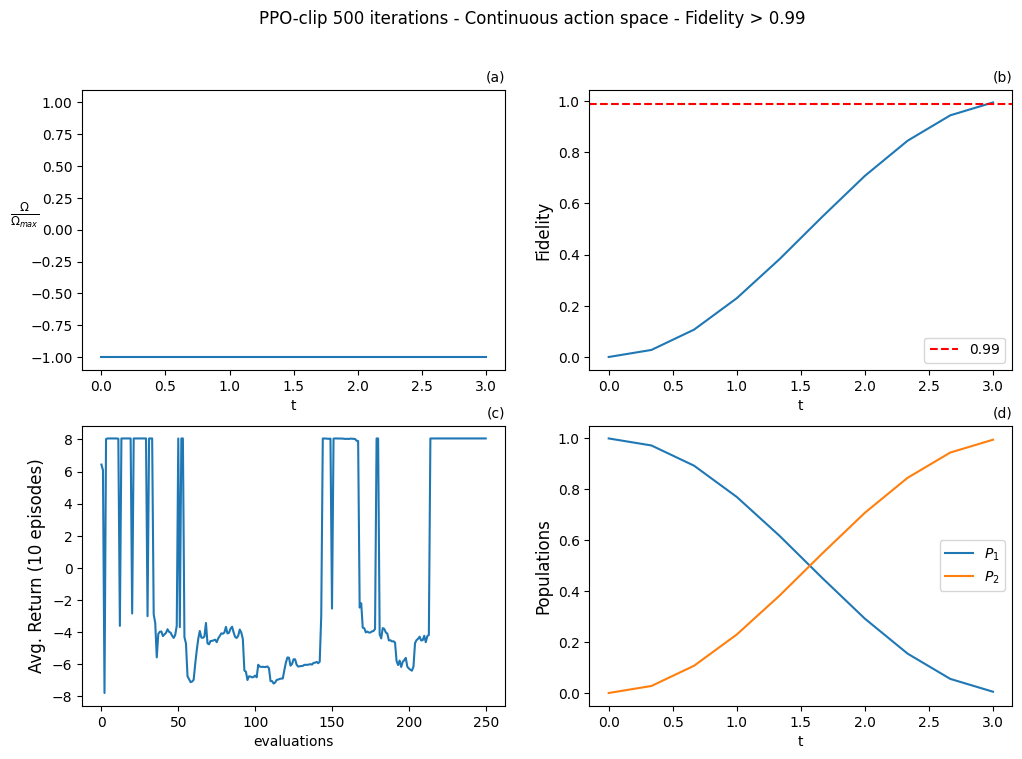

In [10]:
greedy_actions, optimal_omegas, states, fidelities = extract_single_action_policy(environment, agent)

population2 = expect(sigmap().dag() * sigmap(), states)
population1 = 1 - population2

time_span = np.arange(len(optimal_omegas))
time_span = [t * T / max_steps for t in time_span]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(12)
fig.suptitle(f'PPO-clip {num_iterations} iterations - Continuous action space - Fidelity > 0.99')

ax1.step(time_span, optimal_omegas, where = 'post', label = 'Ω')
ax1.set_ylabel(r"$\frac{\Omega}{\Omega_{max}}$", rotation = 0, fontsize = 12)
ax1.set_ylim((-1.1, 1.1))
ax1.set_xlabel(f"t")
ax1.set_title("(a)", loc = "right", fontsize = 10)

ax2.plot(time_span, fidelities)
ax2.axhline(y = 0.99, color = 'r', linestyle = '--', label = '0.99')
ax2.set_ylabel("Fidelity", rotation = 90, fontsize = 12)
ax2.set_xlabel(f"t")
ax2.set_title("(b)", loc = "right", fontsize = 10)
ax2.legend(loc = 'lower right')

ax4.plot(time_span, population1, label = r"$P_1$")
ax4.plot(time_span, population2, label = r"$P_2$")
ax4.set_ylabel("Populations", rotation = 90, fontsize = 12)
ax4.set_xlabel(f"t")
ax4.set_title("(d)", loc = "right", fontsize = 10)
ax4.legend()

time_span3 = range(len(avg_returns))
ax3.plot(time_span3, avg_returns)
ax3.set_ylabel("Avg. Return (10 episodes)", rotation = 90, fontsize = 12)
ax3.set_xlabel(f"evaluations")
ax3.set_title("(c)", loc = "right", fontsize = 10)
plt.show()